In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy.signal import stft
import glob
import os

In [2]:
data_dir = os.path.expanduser("~/Documents/Senior/Fall/Clinic/Data Cleaner/tarsalis_data_clean")
os.chdir(data_dir)
filenames = glob.glob('*.csv')
dataframes = [pd.read_csv(f) for f in filenames]

In [3]:
all_data = pd.concat(dataframes)

In [24]:
distribution = np.unique(all_data['labels'].values, return_counts = True)
dist_df = pd.DataFrame({"label" : distribution[0], "count" : distribution[1]})

Text(0.5, 1.0, 'Label Distribution')

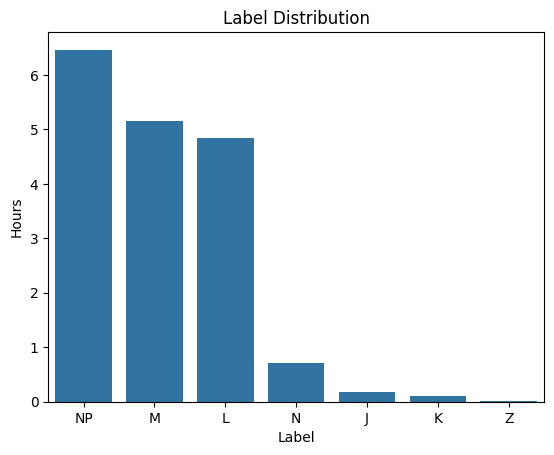

In [38]:
import seaborn as sns
dist_df['hours'] = dist_df['count'] / (100 * 60 * 60)
sns.barplot(data = dist_df.sort_values('count', ascending=False), x = "label", y = "hours")
plt.xlabel("Label")
plt.ylabel("Hours")
plt.title("Label Distribution")

In [40]:
all_data.columns

Index(['Unnamed: 0', 'resistance', 'voltage', 'current', 'time', 'pre_rect',
       'post_rect', 'labels'],
      dtype='object')

In [44]:
np.unique(all_data['current'], return_counts = True)

(array(['AC', 'AC ', 'DC'], dtype=object),
 array([3435152,  195980, 2650892], dtype=int64))

In [39]:
sum(dist_df['hours'])

17.450066666666668

In [3]:
changepoints = []
label_series = []

for df in dataframes:
    x = df["pre_rect"].values
    first_time = np.argmax(x > 0)
    last_time = len(x) - np.argmax(x[::-1] > 0)
    cp = []
    labels = df["labels"].values[first_time:last_time]
    for i in range(len(labels)):
        if i > 0:
            if labels[i] != labels[i - 1]:
                cp.append(i)
        if i == len(labels) - 1:
            cp.append(i)
    changepoints.append(cp)
    label_series.append(labels)

In [49]:
sample_rate = 100 #Hz
window_size = 256
frequency_series = []
time_series = []

for df in dataframes:
    x = df["pre_rect"].values
    first_time = np.argmax(x > 0)
    last_time = len(x) - np.argmax(x[::-1] > 0)
    f, t, Zxx = stft(x[first_time:last_time], fs = sample_rate, nperseg = window_size)
    mags = np.abs(Zxx[1:, :])
    frequency_series.append(mags)
    time_series.append(t)

In [5]:
import seaborn as sns
import umap

In [50]:
len(label_series[0][::window_size//2])

587

In [51]:
frequency_series[0][:, :-1].shape[1]

587

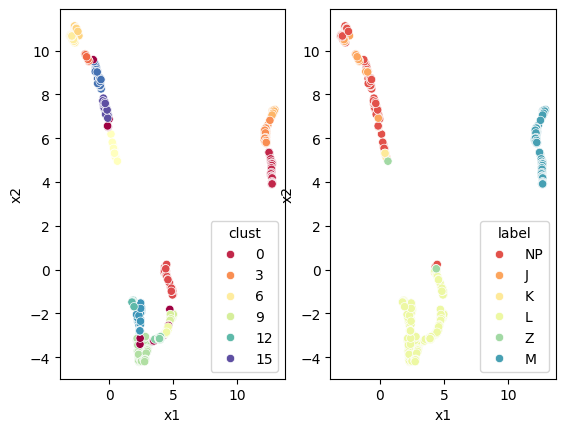

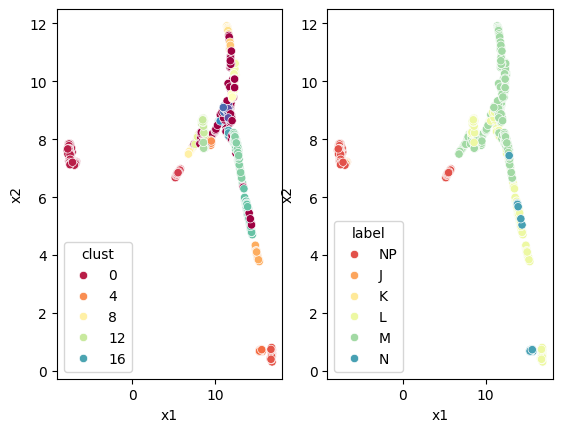

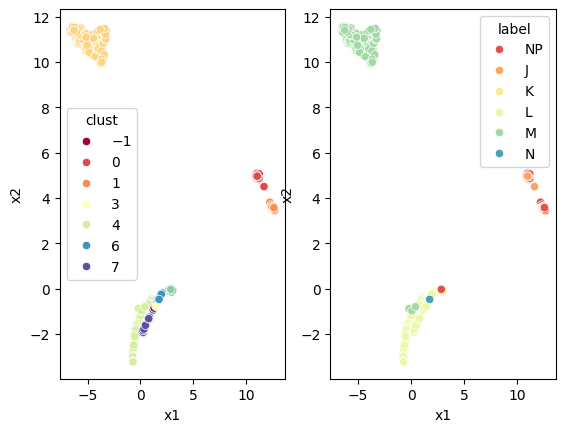

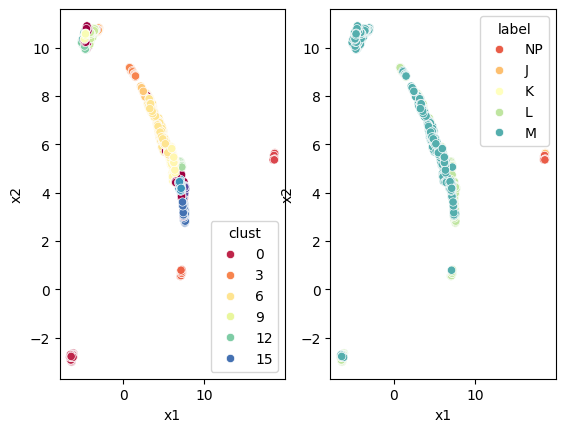

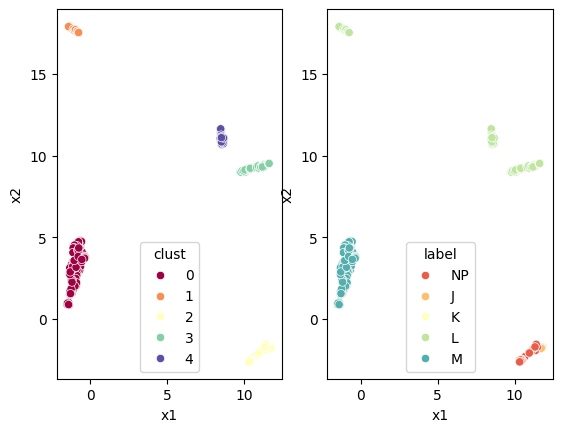

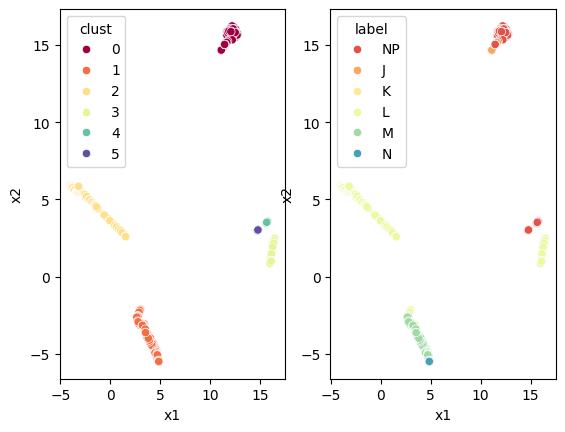

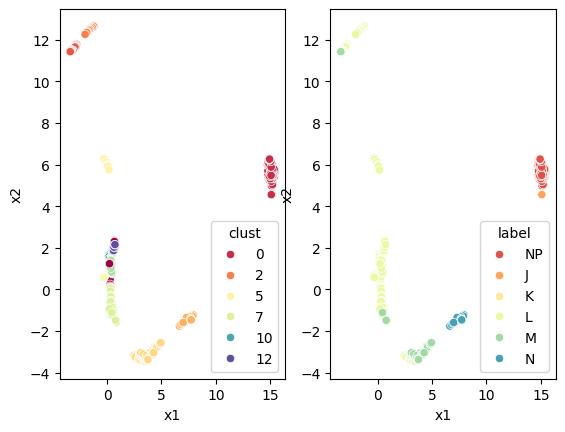

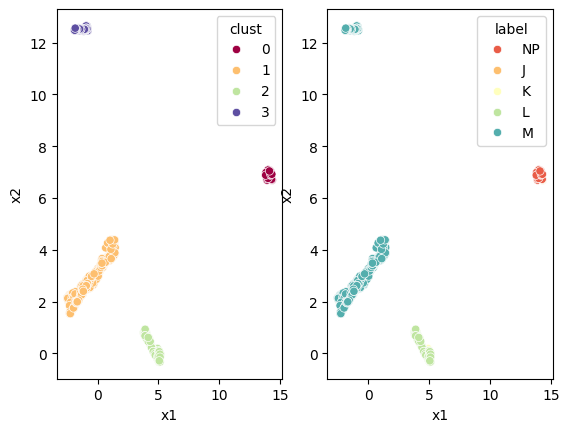

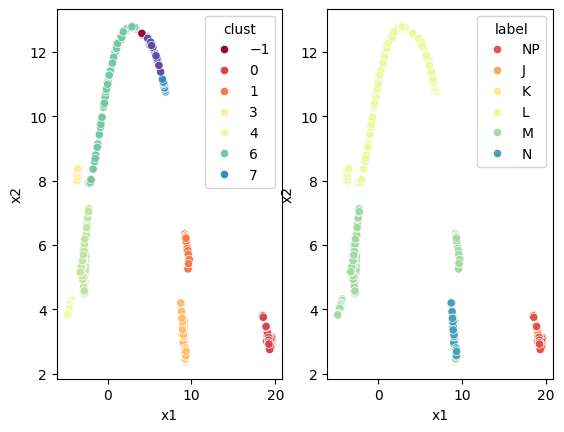

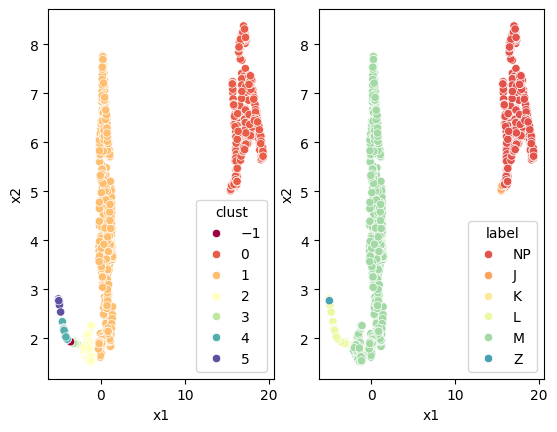

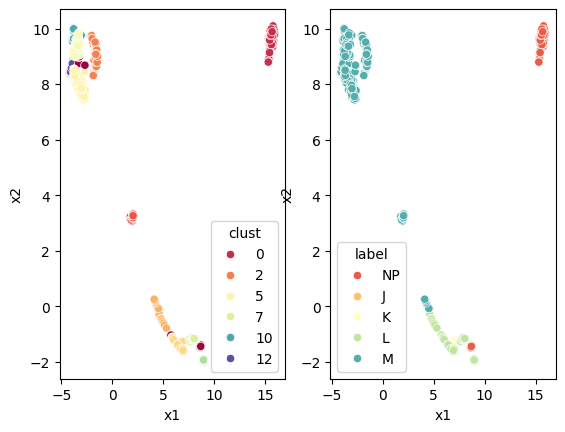

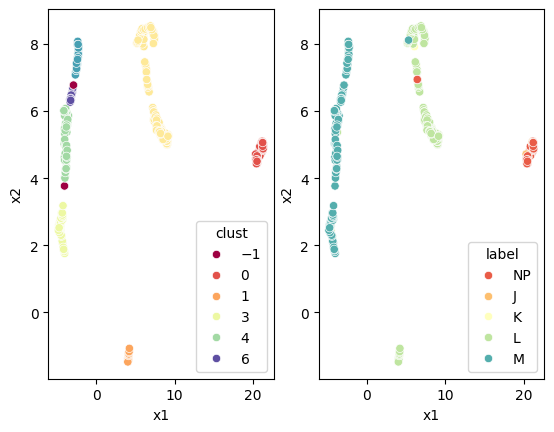

KeyboardInterrupt: 

In [91]:
reducer = umap.UMAP(min_dist = 0, n_components = 2)
for i in range(len(frequency_series)):
    embedding = reducer.fit_transform(frequency_series[i][:, :-1].T)
    hdb = HDBSCAN(min_cluster_size = 10)
    hdb.fit(embedding)
    data = pd.DataFrame({"x1" : embedding[:, 0], 
                         "x2" : embedding[:, 1],
                         "label" : label_series[i][::window_size // 2],
                         "clust" : hdb.labels_})
    fig, axs = plt.subplots(1, 2)
    sns.scatterplot(data=data, x = "x1", y = "x2", hue = "clust", palette = "Spectral", ax = axs[0])
    sns.scatterplot(data=data, x = "x1", y = "x2", hue = "label", palette = "Spectral", ax = axs[1])
    plt.show()

ValueError: 'c' argument has 733 elements, which is inconsistent with 'x' and 'y' with size 98686.

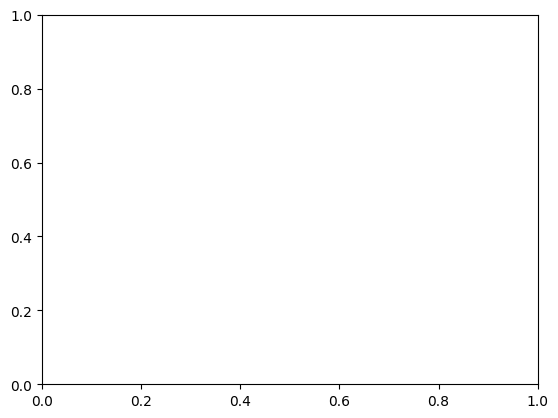

In [85]:
plt.scatter(dataframes[1]["time"], dataframes[1]["pre_rect"], s = 1)
plt.vlines(np.array(changepoints[1]) // 128, ymin = -2, ymax = 2, colors = "black")

In [62]:
from sklearn.cluster import HDBSCAN

In [82]:
hdb = HDBSCAN()
hdb.fit(frequency_series[1].T)

HDBSCAN(min_cluster_size=30)

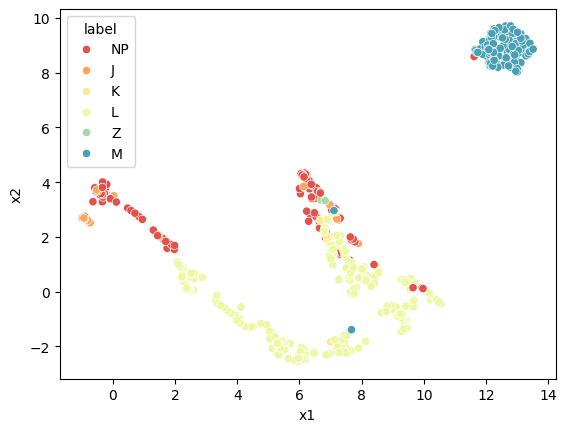

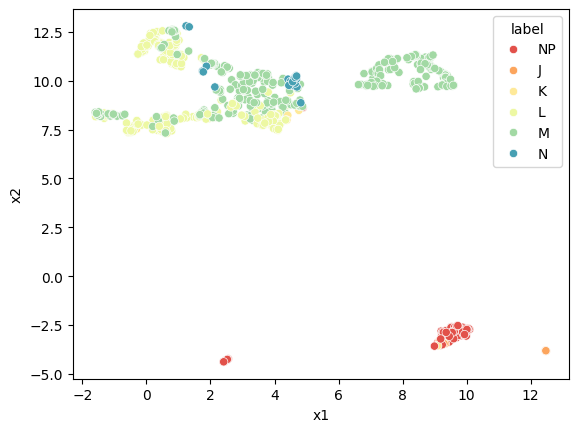

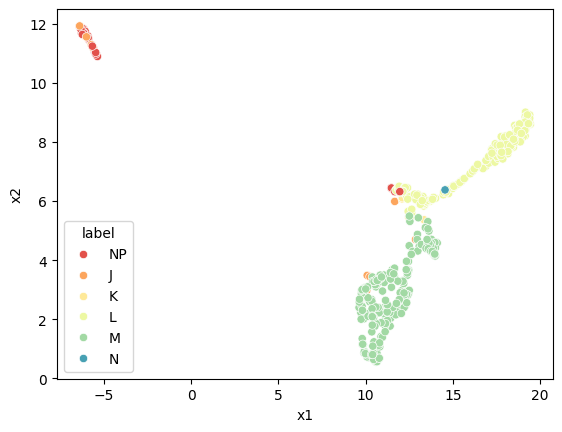

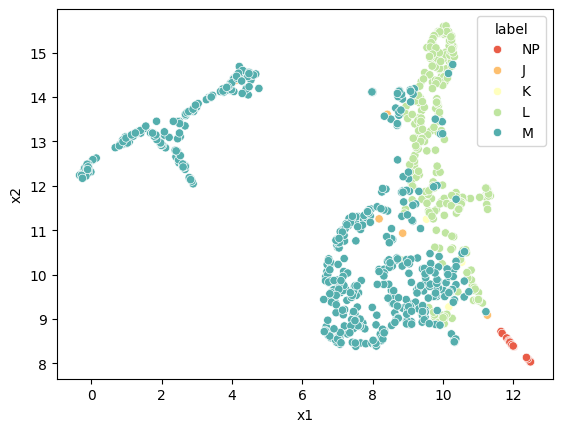

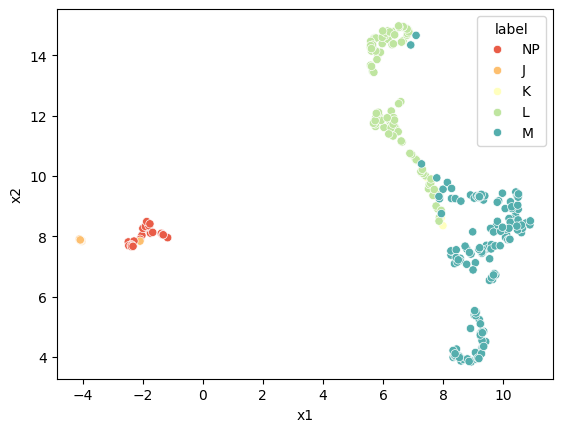

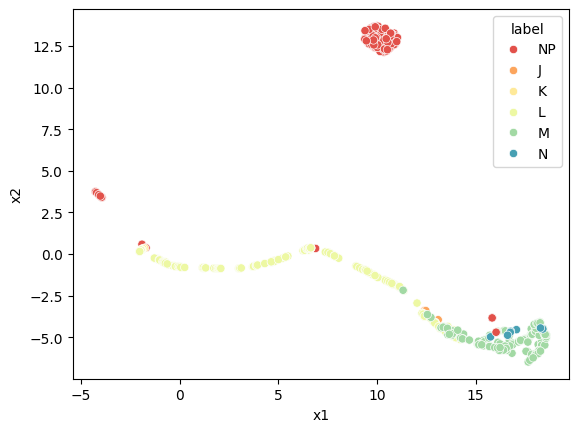

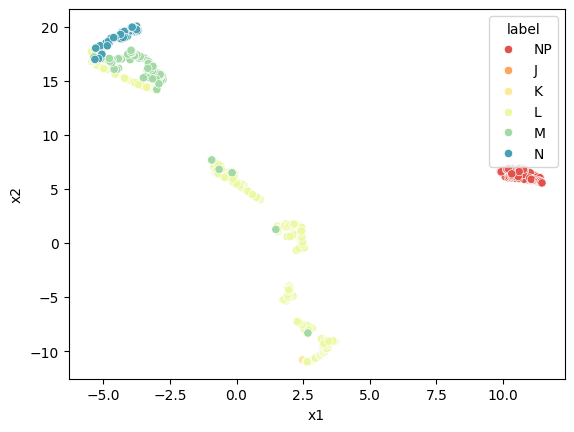

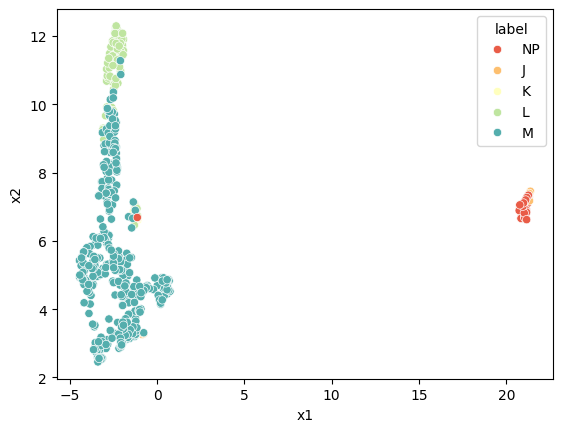

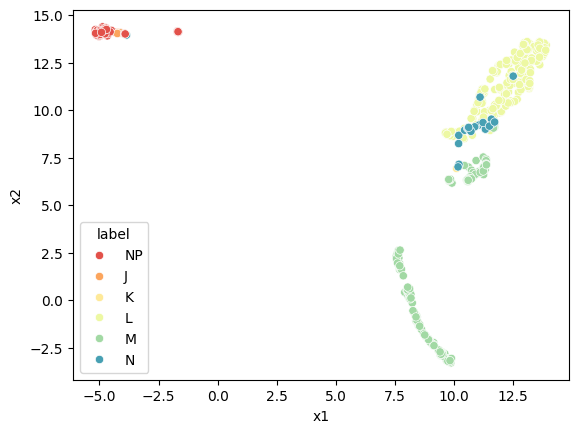

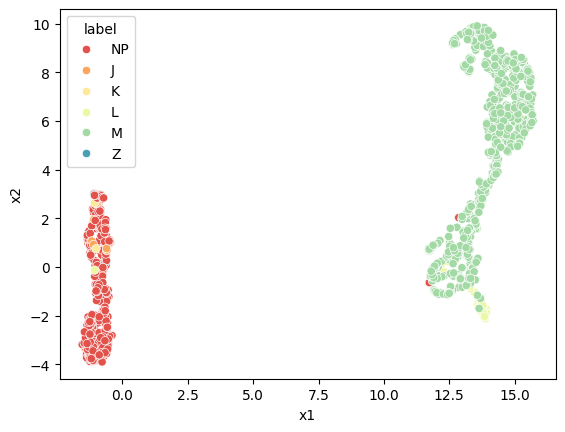

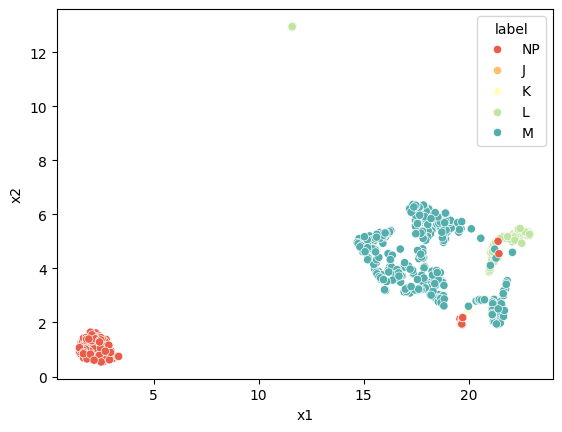

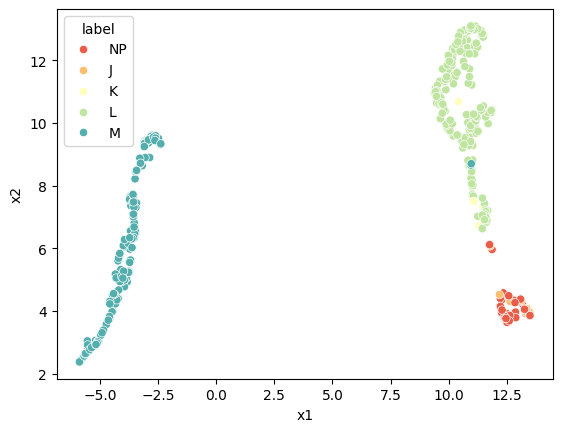

Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x0000028C22366840>
Traceback (most recent call last):
  File "C:\Users\zbtra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\llvmlite\binding\executionengine.py", line 178, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):

KeyboardInterrupt: 


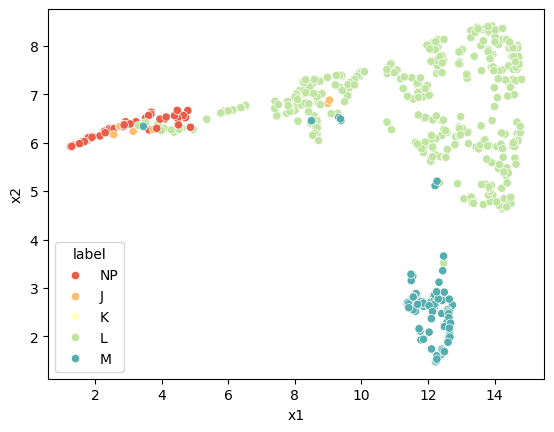

KeyboardInterrupt: 

In [126]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_series = [scaler.fit_transform(f) for f in frequency_series]

reducer = umap.UMAP(min_dist = 0, n_components = 2)
for i in range(len(frequency_series)):
    embedding = reducer.fit_transform(scaled_series[i][:, :-1].T)
    data = pd.DataFrame({"x1" : embedding[:, 0], 
                         "x2" : embedding[:, 1],
                         "label" : label_series[i][::window_size // 2]})
    plt.figure()
    sns.scatterplot(data=data, x = "x1", y = "x2", hue = "label")
    plt.show()

In [127]:
from hmmlearn import hmm

In [142]:
model = hmm.GaussianHMM(n_components = 6)
model.fit(dataframes[0]["pre_rect"].values.reshape(-1, 1))

GaussianHMM(n_components=6)

In [143]:
states = model.predict(frequency_series[0].T)

In [144]:
plt.plot(model.mus_[states])

AttributeError: 'GaussianHMM' object has no attribute 'mus_'